In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import numba as nb
import matplotlib.pyplot as plt

from scipy import optimize
from consav import linear_interp

# load the DurableConsumptionModel module
from BufferStockModel import ConSavModelClass

# Set the number of threads in numba
# nb.set_num_threads(4)

This notebook serves to illustrate first the implications of a standard buffer-stock model. Afterwards, the results for an extended model with individual fixed effects and heterogeneous income profiles are.

## Standard Buffer-Stock

Solve and simulate

In [41]:
model = ConSavModelClass()

In [44]:
model.solve(algo='egm', do_print = False)

In [45]:
model.prepare_simulate(algo='hist')
model.simulate_hist_alt()

model prepared for simulation in 0.0 secs
model simulated in 3.3 secs [256 iterations]


Plot the results

In [46]:
par = model.par
sol = model.sol
sim = model.sim

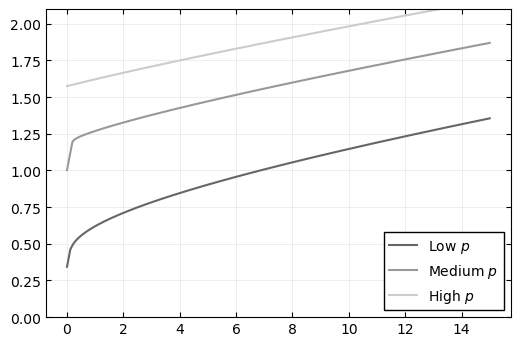

In [47]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)


ax.plot(par.a_grid,sol.c[0,:], color = '0.4', label = 'Low $p$',zorder=2)
ax.plot(par.a_grid,sol.c[3,:], color = '0.6', label = 'Medium $p$',zorder=2)
ax.plot(par.a_grid,sol.c[-1,:], color = '0.8', label = 'High $p$',zorder=2)


ax.set_ylim(0,2.1)
# ax.set_xlim(0,5)

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')
ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.show()


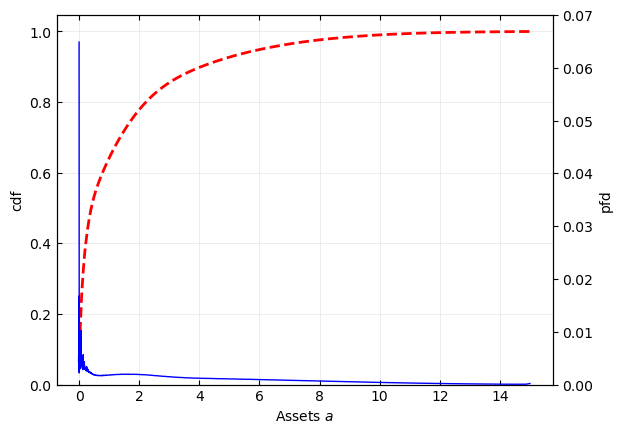

In [100]:
# Distribution matrix (two-dimensional)
D = sim.D_

# Compute density by weighted sum of each row
pdf = np.sum(D,axis=(0,))

# Compute CDF as the cumulative sum over the pdf
cdf = np.cumsum(pdf)

# Run figure
fig, ax1 = plt.subplots()

ax1.plot(par.a_grid, cdf, ls='--', c = 'red', lw=2, label='CDF, left axis',zorder=2)
ax1.set_xlabel('Assets $a$')
ax1.set_ylabel('cdf')

ax1.set_ylim(0) 
ax1.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9')
ax1.tick_params(axis='both',bottom=True,top=True,left=True,right=True,direction='in',which='both')


ax2 = ax1.twinx()
ax2.set_ylim(0,0.07) 

ax2.plot(par.a_grid, pdf, ls='-', c = 'blue', lw=1, label='PDF, right axis',zorder=1)
ax2.set_xlabel('Assets $a$')
ax2.set_ylabel('pfd')


# ax1.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False, loc = 4)

plt.show()

## FE model

To add in the model
- Finite lifetime
- Individual $\beta$'s
- Individual innate ability
- Individual choice of level and shape